<a href="https://colab.research.google.com/github/sanskruti0ise/fin_news_sentiment/blob/main/finance_news_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Finance News Sentimental Analysis**

**Task 1: Data Collection and Preprocessing**

Used the following commands on terminal:
* Merged all the necessary files into one :  **cat ./* > merged-file.txt**
* Removed Duplicates : **sort  --random-sort -u merged-file.txt > sorted-unique.txt**
* Converted the text file to csv with '@' as delimiter for ease:

                    import pandas as pd
                    account = pd.read_csv("sorted-unique.txt", delimiter = '@', encoding="ISO-8859-1")
                    account.to_csv('fin.csv', header=['news_article','sentiment'])  



**Download the csv file from drive link**

#**Exploratory Data Analysis and Preprocessing**

In [1]:
import gdown

file_id = '1C-OVF0h-YU5npLTG95qIU6Di71hYUZhJ'
url = f'https://drive.google.com/uc?id={file_id}'
output = 'fin.csv'  # Change this to your desired file name and extension
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1C-OVF0h-YU5npLTG95qIU6Di71hYUZhJ
To: /content/fin.csv
100%|██████████| 694k/694k [00:00<00:00, 70.2MB/s]


'fin.csv'

**Installation and Imports**

In [2]:
!pip install transformers
!pip install pyarrow==15.0.2
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 13.8 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 15.0.2 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1

In [3]:
from transformers import BertTokenizer, Trainer, BertForSequenceClassification, TrainingArguments, DistilBertTokenizerFast,DistilBertForSequenceClassification
import pandas as pd
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
from collections import Counter, defaultdict
import torch
import transformers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,precision_score,accuracy_score,f1_score
import warnings
from datasets import Dataset
warnings.filterwarnings('ignore')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
#Setting and Checking GPU
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


**Load the dataset and perform an initial exploration.**

Initial CSV file looks like:

In [5]:
fin_file = "/content/fin.csv"
data = pd.read_csv(fin_file)
data.drop('Unnamed: 0', axis=1, inplace=True)

data.drop(data.filter(regex="Unnamed"),axis=1, inplace=True)
data

,news_article,sentiment
0,Finnish investment group Norvestia Oyj said it...,negative
1,The total emissions reduction from 1999 to 201...,neutral
2,Technopolis has approximately 130 customer com...,neutral
3,The liquidity providing was interrupted on May...,negative
4,27 January 2011 - Finnish IT solutions provide...,positive
...,...,...
4834,"The price of the 10,000 kroon par value bonds ...",neutral
4835,The measures result from weak demand in the sh...,negative
4836,As production of other products will continue ...,negative
4837,The maritime administration said the ships had...,negative


In [6]:
data.shape

(4839, 2)

To check if any value is empty.:

In [7]:
data.isna().sum()

,0
news_article,0
sentiment,0


Percentage of each sentiment in the data

In [8]:
data.sentiment.value_counts()/data.shape[0]

,count
sentiment,
neutral,0.593511
positive,0.281670
negative,0.124819


[Text(0, 0, '2872'), Text(0, 0, '1363'), Text(0, 0, '604')]

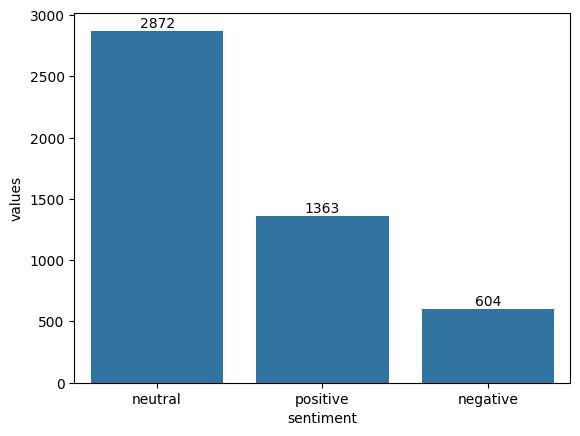

In [9]:
counts = data['sentiment'].value_counts().rename_axis('sentiment').reset_index(name='values')

ax = sns.barplot(x='sentiment', y='values', data=counts)
ax.bar_label(ax.containers[0])

**Preprocess the text data to remove noise, such as punctuation and stopwords, and perform
tokenization.**

In [10]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def cleaning_data(text):
  text = str(text).lower()
  text = text.replace('{html}', "")
  cleanr = re.compile('<.*?>')
  cleantext = re.sub(cleanr, '', text)
  rem_url=re.sub(r'http\S+', '',cleantext)
  rem_num = re.sub('[0-9]+', '', rem_url)
  tokenizer = RegexpTokenizer(r'\w+')
  tokens = tokenizer.tokenize(rem_num)
  filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
  stem_words=[stemmer.stem(w) for w in filtered_words]
  lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
  return " ".join(filtered_words)
data['news_article']=data['news_article'].map(lambda s:cleaning_data(s))

In [11]:
def ngrams(input, n):
    output = []
    for i in range(len(input)-n+1):
        output.append('_'.join(input[i:i+n]))
    return output

In [12]:
nltk.download('punkt')
tags = ['neutral','negative','positive']

df = data[data.sentiment.isin(tags)]
df['Tokens'] = df.apply(lambda row: nltk.word_tokenize(row['news_article'].strip()), axis=1)
df['bi_Grams']  = df.apply(lambda row: ngrams(row['Tokens'], 2), axis=1)
df['tri_Grams']  = df.apply(lambda row: ngrams(row['Tokens'], 3), axis=1)
print(len(df),'samples from',len(tags),'classes')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


4839 samples from 3 classes


In [13]:
c_unique = Counter()
for ind in df.index:
    c_unique.update(Counter(set(df.loc[ind]['Tokens'])))

print('First 20 common words:\n')
for word in c_unique.most_common(20):
    print(word[0],'-->', 'appeared in',word[1],'documents out of {} documents i.e.'.format(len(df)),np.round(100*word[1]/len(df),2),'%')

First 20 common words:

eur --> appeared in 801 documents out of 4839 documents i.e. 16.55 %
company --> appeared in 799 documents out of 4839 documents i.e. 16.51 %
said --> appeared in 543 documents out of 4839 documents i.e. 11.22 %
finnish --> appeared in 512 documents out of 4839 documents i.e. 10.58 %
sales --> appeared in 428 documents out of 4839 documents i.e. 8.84 %
profit --> appeared in 406 documents out of 4839 documents i.e. 8.39 %
net --> appeared in 384 documents out of 4839 documents i.e. 7.94 %
year --> appeared in 341 documents out of 4839 documents i.e. 7.05 %
finland --> appeared in 330 documents out of 4839 documents i.e. 6.82 %
million --> appeared in 311 documents out of 4839 documents i.e. 6.43 %
group --> appeared in 302 documents out of 4839 documents i.e. 6.24 %
operating --> appeared in 294 documents out of 4839 documents i.e. 6.08 %
new --> appeared in 261 documents out of 4839 documents i.e. 5.39 %
business --> appeared in 251 documents out of 4839 docume

In [14]:
sent = data.sentiment.unique()
index = [i for i in range(len(sent.tolist()))]
label = dict(zip(sent, index))

sent = list(sent)
data['label'] = data.sentiment.replace(label)
data.head()

,news_article,sentiment,label
0,finnish investment group norvestia oyj said ne...,negative,0
1,total emissions reduction thus,neutral,1
2,technopolis approximately customer companies j...,neutral,1
3,liquidity providing interrupted may aspocomp g...,negative,0
4,january finnish solutions provider affecto oyj...,positive,2


In [15]:
df_temp, df_test = train_test_split(data, test_size=0.2, random_state=42, stratify=data['sentiment'])
df_train, df_val = train_test_split(df_temp, test_size=0.1, random_state=42, stratify=df_temp['sentiment'])


In [16]:
print("size of training set : " + str(df_train.shape[0]))
print("size of validation set : " + str(df_val.shape[0]))
print("size of test set : " + str(df_test.shape[0]))

size of training set : 3483
size of validation set : 388
size of test set : 968


In [17]:
from sklearn.utils import resample

sentiment = data.sentiment.unique()
max = 2
target_majority = data[data.sentiment==sentiment[max]]


for cl in range(3):
    train_minority = df_train[df_train.sentiment==sentiment[cl]]
    train_minority_upsampled = resample(train_minority, replace=True, n_samples=len(target_majority), random_state=33)
    if cl == 0:
        train_upsampled = pd.concat([train_minority_upsampled, target_majority])
        #train_upsampled = pd.concat([train_upsampled, ])
    if cl>0 and cl!=max:
        train_upsampled = pd.concat([train_minority_upsampled, train_upsampled])

train_upsampled['sentiment'].value_counts()

,count
sentiment,
neutral,1363
negative,1363
positive,1363


#**Classical Machine Learning Classifier:**
*   **Naive Bayes**
*  **SVM**

In [18]:
#Classifier = Classifier.replace('\'', '')

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report

Naive_Bayes = MultinomialNB()
SVM = SVC(kernel='linear', C=1.0, random_state=42)
Classifier = "Naive_Bayes" # @param ["Naive_Bayes", "SVM"]
if Classifier == "Naive_Bayes":
  Classifier = Naive_Bayes
elif Classifier == "SVM":
  Classifier = SVM


# Load dataset (replace with your dataset path)
df = pd.read_csv('/content/fin.csv')

# Preprocess the text data
X = df['news_article']  # Text data
y = df['sentiment']  # Labels (e.g., positive, negative, neutral)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Vectorize text data using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train the Classifier model
model = Classifier
model.fit(X_train_tfidf, y_train)


# Make predictions
y_pred = model.predict(X_test_tfidf)

# Evaluate the model
print("Classification Report for: ", Classifier)
print(classification_report(y_test, y_pred))

Classification Report for:  MultinomialNB()
              precision    recall  f1-score   support

    negative       0.70      0.09      0.17       169
     neutral       0.70      0.96      0.81       874
    positive       0.65      0.35      0.46       409

    accuracy                           0.69      1452
   macro avg       0.68      0.47      0.48      1452
weighted avg       0.68      0.69      0.64      1452



Predict Sentiment Function:

In [19]:
def predict_sentiment(sentence):
    # Transform the input sentence using the same vectorizer
    sentence_tfidf = vectorizer.transform([sentence])

    # Make a prediction
    prediction = model.predict(sentence_tfidf)

    return prediction[0]

# Test with a custom sentence
custom_sentence = "The company's financial report shows strong growth this quarter."
sentiment = predict_sentiment(custom_sentence)
print(f"The sentiment of the sentence is: {sentiment}")

The sentiment of the sentence is: neutral


#**Model list**
*  **DistilBERT : distilbert-base-uncased**
*  **TinyBERT : Intel/dynamic_tinybert**
*  **MiniLM  : microsoft/MiniLM-L12-H384-uncased2**

Select model of your choice from the dropdown below

Select 0/1/2 according to Model List

In [20]:
model_list = "Intel/dynamic_tinybert" # @param  ["distilbert-base-uncased", "Intel/dynamic_tinybert", "microsoft/MiniLM-L12-H384-uncased"]

model = BertForSequenceClassification.from_pretrained(model_list,num_labels=3)
tokenizer = BertTokenizer.from_pretrained(model_list)

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Intel/dynamic_tinybert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/351 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [21]:
dataset_train = Dataset.from_pandas(train_upsampled)
dataset_val = Dataset.from_pandas(df_val)
dataset_test = Dataset.from_pandas(df_test)

dataset_train = dataset_train.map(lambda e: tokenizer(e['news_article'], truncation=True, padding='max_length', max_length=128), batched=True)
dataset_val = dataset_val.map(lambda e: tokenizer(e['news_article'], truncation=True, padding='max_length', max_length=128), batched=True)
dataset_test = dataset_test.map(lambda e: tokenizer(e['news_article'], truncation=True, padding='max_length' , max_length=128), batched=True)

dataset_train.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_val.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_test.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/4089 [00:00<?, ? examples/s]

Map:   0%|          | 0/388 [00:00<?, ? examples/s]

Map:   0%|          | 0/968 [00:00<?, ? examples/s]

In [22]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'accuracy' : accuracy_score(predictions, labels)}

In [23]:
args = TrainingArguments(
        output_dir = 'output/',
        evaluation_strategy="steps",
        num_train_epochs=5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=64,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs_dir',
        #logging_steps=10,
        load_best_model_at_end=True,
)

In [24]:
trainer = Trainer(
        model=model,
        args=args,
        train_dataset=dataset_train,
        eval_dataset=dataset_val,
        compute_metrics=compute_metrics
)

trainer.train()

Step,Training Loss,Validation Loss,Accuracy
500,0.518300,0.490241,0.842784


TrainOutput(global_step=640, training_loss=0.4381179720163345, metrics={'train_runtime': 206.2686, 'train_samples_per_second': 99.118, 'train_steps_per_second': 3.103, 'total_flos': 677086066033920.0, 'train_loss': 0.4381179720163345, 'epoch': 5.0})

In [25]:
model.eval()
trainer.predict(dataset_test).metrics

{'test_loss': 0.5164406299591064,
 'test_accuracy': 0.8274793388429752,
 'test_runtime': 3.4033,
 'test_samples_per_second': 284.428,
 'test_steps_per_second': 4.701}

In [26]:
preds = trainer.predict(dataset_test)

In [27]:
probs = torch.from_numpy(preds[0]).softmax(1)
predictions = probs.numpy()# convert tensors to numpy array

new_df = pd.DataFrame(predictions,columns=data.sentiment.unique())
new_df.head()

,negative,neutral,positive
0,0.002366,0.984001,0.013633
1,0.002058,0.072070,0.925872
2,0.001531,0.939476,0.058993
3,0.001545,0.979602,0.018852
4,0.004075,0.009451,0.986474


In [28]:
df_test_distil_bert = df_test.copy()

results = np.argmax(predictions,axis=1)

df_test_distil_bert['Sentiment_pred'] = results
df_test_distil_bert['Sentiment_pred'] = df_test_distil_bert['Sentiment_pred']
df_test_distil_bert['label_pred'] = results


emotion = {0: 'negative', 1: 'neutral', 2: 'positive'}
df_test_distil_bert['Sentiment_pred'] = df_test_distil_bert['Sentiment_pred'].map(emotion )

df_test_distil_bert.head()

,news_article,sentiment,label,Sentiment_pred,label_pred
2588,exel headquartered mantyharju finland,neutral,1,neutral,1
4471,beyond improved voice capabilities customers s...,positive,2,positive,2
2184,expo signature show dongguan supported donggua...,neutral,1,neutral,1
2453,yvonne jones owner chameleon interiors,neutral,1,neutral,1
899,also lemmink ñinen profit accounting period we...,positive,2,positive,2


In [29]:
print('Classification_report of', model_list, 'Model:')

print(classification_report(df_test_distil_bert['sentiment'], df_test_distil_bert['Sentiment_pred']))

Classification_report of Intel/dynamic_tinybert Model:
              precision    recall  f1-score   support

    negative       0.77      0.71      0.74       121
     neutral       0.94      0.80      0.87       574
    positive       0.69      0.93      0.79       273

    accuracy                           0.83       968
   macro avg       0.80      0.81      0.80       968
weighted avg       0.85      0.83      0.83       968



In [30]:
!zip -r /content/minilm.zip /content/output

  adding: content/output/ (stored 0%)
  adding: content/output/checkpoint-640/ (stored 0%)
  adding: content/output/checkpoint-640/rng_state.pth (deflated 25%)
  adding: content/output/checkpoint-640/config.json (deflated 51%)
  adding: content/output/checkpoint-640/scheduler.pt (deflated 56%)
  adding: content/output/checkpoint-640/optimizer.pt (deflated 34%)
  adding: content/output/checkpoint-640/trainer_state.json (deflated 57%)
  adding: content/output/checkpoint-640/model.safetensors (deflated 7%)
  adding: content/output/checkpoint-640/training_args.bin (deflated 51%)
  adding: content/output/checkpoint-500/ (stored 0%)
  adding: content/output/checkpoint-500/rng_state.pth (deflated 25%)
  adding: content/output/checkpoint-500/config.json (deflated 51%)
  adding: content/output/checkpoint-500/scheduler.pt (deflated 57%)
  adding: content/output/checkpoint-500/optimizer.pt (deflated 34%)
  adding: content/output/checkpoint-500/trainer_state.json (deflated 57%)
  adding: content/o

#**Flask API**

**Installation:**

In [31]:
!pip install flask
!pip install flask-ngrok
!pip install pyngrok

**Ngrok Authentication:**

In [32]:
!ngrok authtoken 2kKfyEEqxBYAVnkANqpYevnqMyz_5dE1E4fRGnC4H3i8kVfX4

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [33]:
from pyngrok import ngrok
public_url = ngrok.connect(5000)
print(public_url)

NgrokTunnel: "https://8a5c-35-185-200-215.ngrok-free.app" -> "http://localhost:5000"


In [ ]:
from flask import Flask, request, jsonify
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from flask_ngrok import run_with_ngrok
import logging

# Initialize Flask app
app = Flask(__name__)
run_with_ngrok(app)  # Start ngrok when app is run

# Setup logging
logging.basicConfig(level=logging.DEBUG)

# Load the fine-tuned model and tokenizer
model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained('/content/output/checkpoint-640', local_files_only=True)

# Define a function to preprocess and predict the sentiment
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
    prediction = torch.argmax(logits, dim=1).item()
    sentiment = ['negative', 'neutral', 'positive'][prediction]
    return sentiment

# Define the root endpoint
@app.route('/')
def home():
    return "Welcome to the Sentiment Analysis API. Use the /predict endpoint to get predictions."

# Define the predict endpoint
@app.route('/predict', methods=['GET', 'POST'])
def predict():
    try:
        data = request.get_json()
        app.logger.debug("Received data: %s", data)
        if 'text' not in data:
            return jsonify({'error': 'No text field provided'}), 400
        text = data['text']
        sentiment = predict_sentiment(text)
        return jsonify({'sentiment': sentiment})
    except Exception as e:
        app.logger.error("Error occurred: %s", str(e))
        return jsonify({'error': str(e)}), 500

# Run the Flask app
if __name__ == '__main__':
    app.run()


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


 * Running on http://8a5c-35-185-200-215.ngrok-free.app
 * Traffic stats available on http://127.0.0.1:4040
